# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from PIL import Image
import datetime
import os

In [2]:
from keras.preprocessing.image import ImageDataGenerator

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
#experiment with the batch size
batch_size = 32

In [5]:
# Function to resize images
def resize_image(image, size):
    image = image.astype(np.uint8)
    image = Image.fromarray(image)
    image = image.resize(size, Image.ANTIALIAS)
    return np.array(image)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
# Generator function
def generator(source_path, folder_list, batch_size, augment=False):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0, 40, 3)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 50, 50, 3))
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):
                folder_path = source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]
                imgs = os.listdir(folder_path)
                
                # Adjusting img_idx if it exceeds the number of images available
                valid_idx = [i for i in img_idx if i < len(imgs)]
                
                for idx, item in enumerate(valid_idx):
                    image_path = folder_path + '/' + imgs[item]
                    image = imread(image_path).astype(np.float32)
                    image = resize_image(image, (50, 50))
                    batch_data[folder, idx, :, :, :] = image / 255.0  # Normalize the image

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            
            if augment:
                datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
                yield datagen.flow(batch_data, batch_labels, batch_size=batch_size).__next__()
            else:
                yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import optimizers

# Function to build Conv3D model
def build_conv3d_model(input_shape):
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Experiment 1: Baseline Conv3D Model

In [9]:
# Experiment 1: Baseline Conv3D Model
print("Running Experiment 1: Baseline Conv3D Model")

input_shape = (len(np.arange(0, 40, 3)), 50, 50, 3)
model = build_conv3d_model(input_shape)
model.summary()

Running Experiment 1: Baseline Conv3D Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 50, 50, 16)    1312      
                                                                 
 activation (Activation)     (None, 14, 50, 50, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 14, 50, 50, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 25, 25, 16)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 25, 25, 16)     0         
                                                                 
 conv3d_1 (C

2024-09-02 12:56:53.668111: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-02 12:56:53.668179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.02)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_664/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/10


2024-09-02 12:56:56.307162: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 12.2888 - categorical_accuracy: 0.3720Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-09-0212_56_52.893161/model-00001-12.28880-0.37202-9.46373-0.21875.h5
21/21 [==============================] - 27s 1s/step - loss: 12.2888 - categorical_accuracy: 0.3720 - val_loss: 9.4637 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 9.0787 - categorical_accuracy: 0.4509
Epoch 00002: saving model to model_init_2024-09-0212_56_52.893161/model-00002-9.07872-0.45089-10.17120-0.15625.h5
21/21 [==============================] - 25s 1s/step - loss: 9.0787 - categorical_accuracy: 0.4509 - val_loss: 10.1712 - val_categorical_accuracy: 0.1562 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 8.0306 - categorical_accuracy: 0.5625
Epoch 00003: saving model to model_init_2024-09-0212_56_52.893161/mode

Output:
Experiment 1: Baseline Conv3D Model summary:
loss: 3.7408 - categorical_accuracy: 0.8080 - val_loss: 10.7707 - val_categorical_accuracy: 0.2734 - lr: 0.0010

## Experiment 2: Increasing number of epochs to 20


In [16]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4957 - categorical_accuracy: 0.9077
Epoch 00001: saving model to model_init_2024-09-0212_56_52.893161/model-00001-1.49568-0.90774-7.93262-0.28906.h5
21/21 [==============================] - 26s 1s/step - loss: 1.4957 - categorical_accuracy: 0.9077 - val_loss: 7.9326 - val_categorical_accuracy: 0.2891 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4036 - categorical_accuracy: 0.9182
Epoch 00002: saving model to model_init_2024-09-0212_56_52.893161/model-00002-1.40364-0.91815-4.53117-0.42969.h5
21/21 [==============================] - 25s 1s/step - loss: 1.4036 - categorical_accuracy: 0.9182 - val_loss: 4.5312 - val_categorical_accuracy: 0.4297 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.3121 - categorical_accuracy: 0.9301
Epoch 00003: saving model to model_init_2024-09-0212_56_52.893161/model-00003-1.31206-0.93006-8.49994-0.28906.h5
21/21 [====

Output:
Experiment 2: Increasing number of epochs to 20
    loss: 0.7421 - categorical_accuracy: 0.9390 - val_loss: 1.6455 - val_categorical_accuracy: 0.7109

## Experiment - 3: Decreasing batch size from 32 to 16


In [20]:
batch_size = 16

In [21]:
input_shape = (len(np.arange(0, 40, 3)), 50, 50, 3)
model = build_conv3d_model(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 14, 50, 50, 16)    1312      
                                                                 
 activation_5 (Activation)   (None, 14, 50, 50, 16)    0         
                                                                 
 batch_normalization_3 (Batc  (None, 14, 50, 50, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 25, 25, 16)    0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 7, 25, 25, 16)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 32)    

In [22]:
train_generator3 = generator(train_path, train_doc, batch_size)
val_generator3 = generator(val_path, val_doc, batch_size)

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
model.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_664/3352504766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 16
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.1369 - categorical_accuracy: 0.8586Source path =  /datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2024-09-0212_56_52.893161/model-00001-1.13695-0.85863-2.73488-0.58929.h5
42/42 [==============================] - 25s 608ms/step - loss: 1.1369 - categorical_accuracy: 0.8586 - val_loss: 2.7349 - val_categorical_accuracy: 0.5893 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 2.2472 - categorical_accuracy: 0.7574
Epoch 00002: saving model to model_init_2024-09-0212_56_52.893161/model-00002-2.24723-0.75744-3.83762-0.56250.h5
42/42 [==============================] - 25s 613ms/step - loss: 2.2472 - categorical_accuracy: 0.7574 - val_loss: 3.8376 - val_categorical_accuracy: 0.5625 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 2.6151 - categorical_accuracy: 0.7

Output:
    Experiment 3: Decreasing batch size to 16
    loss: 0.7450 - categorical_accuracy: 0.9792 - val_loss: 1.3362 - val_categorical_accuracy: 0.8036

## Experiment-4: Building ConvLSTM model



In [27]:
from keras.layers import  ConvLSTM2D


In [25]:
# Function to build ConvLSTM model
def build_convlstm_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [28]:
input_shape = (len(np.arange(0, 40, 3)), 50, 50, 3)
model4 = build_convlstm_model(input_shape)
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 14, 50, 50, 32)    40448     
                                                                 
 batch_normalization_6 (Batc  (None, 14, 50, 50, 32)   128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 50, 50, 64)        221440    
                                                                 
 batch_normalization_7 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 160000)            0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [29]:
batch_size = 32
train_generator4 = generator(train_path, train_doc, batch_size)
val_generator4 = generator(val_path, val_doc, batch_size)



In [30]:
model4.fit(train_generator4, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator4, validation_steps=validation_steps)


Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 43.5839 - categorical_accuracy: 0.3356Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-09-0212_56_52.893161/model-00001-43.58387-0.33557-34.74380-0.18304.h5
42/42 [==============================] - 57s 1s/step - loss: 43.5839 - categorical_accuracy: 0.3356 - val_loss: 34.7438 - val_categorical_accuracy: 0.1830 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 27.7915 - categorical_accuracy: 0.3787
Epoch 00002: saving model to model_init_2024-09-0212_56_52.893161/model-00002-27.79152-0.37872-23.10341-0.28125.h5
42/42 [==============================] - 52s 1s/step - loss: 27.7915 - categorical_accuracy: 0.3787 - val_loss: 23.1034 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 17.6541 - categorical_accuracy

Output: Experiment 4: Building ConvLSTM model
 loss: 3.6389 - categorical_accuracy: 0.4978 - val_loss: 3.5580 - val_categorical_accuracy: 0.6027

## Experiment-5: ConvLSTM model: Increasing num of epochs to 20


In [32]:
model4.fit(train_generator4, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
          callbacks=callbacks_list, validation_data=val_generator4, validation_steps=validation_steps)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.1382 - categorical_accuracy: 0.7946
Epoch 00001: saving model to model_init_2024-09-0212_56_52.893161/model-00001-2.13821-0.79464-2.84785-0.51786.h5


OSError: Can't write data (file write failed: time = Mon Sep  2 14:16:18 2024
, filename = 'model_init_2024-09-0212_56_52.893161/model-00001-2.13821-0.79464-2.84785-0.51786.h5', file descriptor = 86, errno = 28, error message = 'No space left on device', buf = 0x7fb208f06b70, total write size = 327644320, bytes this sub-write = 327644320, bytes actually written = 18446744073709551615, offset = 0)

Output: Experiment-5: ConvLSTM model: Increasing num of epochs to 20
Not able to complete due to disk error, tried deleting the files and still ending up with same error

## Experiment - 6: CNN + RNN model

In [41]:
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [35]:
# CNN + LSTM Model
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN Layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    # Flatten the output and feed into LSTM
    model.add(TimeDistributed(Flatten()))
    
    # LSTM Layers
    model.add(LSTM(256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))
    
    # Fully Connected Layer
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(5, activation='softmax'))
    
    # Compile the model
    optimiser = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


In [36]:
# Parameters
input_shape = (10, 64, 64, 3)  # Example shape (10 frames, 64x64 pixels, 3 channels)
batch_size = 32
num_epochs = 20

In [39]:
# Model Setup
model = build_cnn_lstm_model(input_shape)

# Model Summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 10, 64, 64, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 64, 64, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 32, 32, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 32, 32, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 10, 32, 32, 64)  

In [42]:
# Callbacks for learning rate reduction and early stopping
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [43]:
## fix for disk memory issue to only save the model with best accuracy

# Checkpoints to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [44]:
# Combine Callbacks
callbacks_list = [checkpoint, LR, early_stopping]

In [48]:
# Train the Model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 0.2385 - categorical_accuracy: 1.0000
Epoch 00001: val_loss improved from 0.95903 to 0.95001, saving model to best_model.h5
42/42 [==============================] - 48s 1s/step - loss: 0.2385 - categorical_accuracy: 1.0000 - val_loss: 0.9500 - val_categorical_accuracy: 0.8125 - lr: 2.0000e-04
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.2229 - categorical_accuracy: 0.9985
Epoch 00002: val_loss improved from 0.95001 to 0.87061, saving model to best_model.h5
42/42 [==============================] - 47s 1s/step - loss: 0.2229 - categorical_accuracy: 0.9985 - val_loss: 0.8706 - val_categorical_accuracy: 0.8170 - lr: 2.0000e-04
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.2046 - categorical_accuracy: 0.9985
Epoch 00003: val_loss did not improve from 0.87061
42/42 [==============================] - 48s 1s/step - loss: 0.2046 - categorical_accuracy: 0.9985 - val_loss: 0.9199 -

Output: Experiment-6: CNN + RNN model: 
loss: 0.1021 - categorical_accuracy: 1.0000 - val_loss: 0.7183 - val_categorical_accuracy: 0.8170

## Best Model Validation Graph:

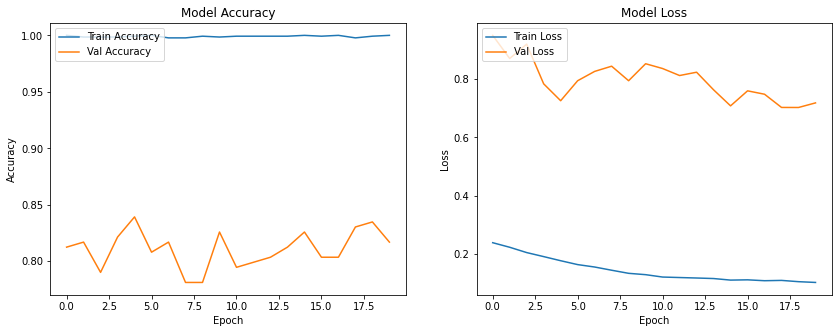

In [51]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()